In [1]:
import warnings
warnings.filterwarnings(action='ignore')
%config Completer.use_jedi = False
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import pandas as pd

Instructions for updating:
non-resource variables are not supported in the long term


***
Word2Vec는 Word To Vector의 줄임말이다.

딥러닝 모델은 입력값으로 숫자를 받기때문에 자연어 처리 분야에서 단어(word)를 어떻게 수치(vector)로 변환하느냐가 딥러닝 모델의 성능을 결정하는 중요한 요소가 된다.  
Word2Vec의 장점은 의미가 비슷한 단어는 벡터 공간에서도 서로 가까운 위치에 존재하게 되는 비지도 학습으로 말뭉치 데이터만 있으면 손쉽게 Word2Vec를 구현할 수 있다.  

***

***
데이터 획득
***

In [2]:
corpus = ['king is a strong man', 
          'queen is a wise woman', 
          'boy is a young man', 
          'girl is a young woman',
          'prince is a young king', 
          'princess is a young queen', 
          'man is strong', 
          'woman is pretty',
          'prince is a boy will be king', 
          'princess is a girl will be queen']
print(corpus)

['king is a strong man', 'queen is a wise woman', 'boy is a young man', 'girl is a young woman', 'prince is a young king', 'princess is a young queen', 'man is strong', 'woman is pretty', 'prince is a boy will be king', 'princess is a girl will be queen']


***
데이터 전처리 - 불용어(stopwords) 제거하기  
불용어란 학습에 도움이 되지 않고 빈번하게 발생하는 단어르 의미하며 효율적인 학습을 위해서 불용어를 데이터에서 제거한다.  
***

In [3]:
# 불용어 제거 함수
def remove_stop_words(corpus):
     stop_words = ['is', 'a', 'will', 'be'] #불용어 정의
     results = [] #불용어를 제거한 결과를 저장해서 리턴시킬 빈 리스트를 선언한다.
     # 불용어를 제거할 문장을 한 줄씩 읽어가며 반복한다.
     for text in corpus:
          #print(text)
          #불용어를 제거하기 위해서 공백을 경계로 문장을 단어 단위로 나눈다.
          temp = text.split()
          #print(temp)
          for stop in stop_words:
               #불용어를 제거할 문장에 불용어가 없을 때까지 반복한다
               while stop in temp:
                     temp.remove(stop)
               #---- while
          #--- for stop
          #print(temp)
          # 불용어 갯수만큼 반복하며 문장에서 불용어를 제거한다.
          # 불용어가 제거된 단어 사이에 공백을 넣어서 불용어가 제거된 문장을 만든다.
          #print(' '.join(temp))
          results.append(' '.join(temp))
     #----- for text
     return results;

In [4]:
remove_stop_words(corpus)
corpus = remove_stop_words(corpus)
print(corpus)

['king strong man', 'queen wise woman', 'boy young man', 'girl young woman', 'prince young king', 'princess young queen', 'man strong', 'woman pretty', 'prince boy king', 'princess girl queen']


***
데이터 전처리 -> 불용어를 제거한 단어의 중복을 제거한다.
***

In [5]:
# 불용어를 제거한 후 데이터에 존재하는 단어들은 다음과 같다.
words = []
for text in corpus:
     for word in text.split():
          words.append(word)
print(words) # 중복되는 단어가 존재한다.

['king', 'strong', 'man', 'queen', 'wise', 'woman', 'boy', 'young', 'man', 'girl', 'young', 'woman', 'prince', 'young', 'king', 'princess', 'young', 'queen', 'man', 'strong', 'woman', 'pretty', 'prince', 'boy', 'king', 'princess', 'girl', 'queen']


In [6]:
words = set(words)
print(words) #중복되는 단어가 존재하지 않는다.

{'man', 'strong', 'pretty', 'wise', 'woman', 'girl', 'king', 'queen', 'prince', 'princess', 'young', 'boy'}


***
데이터 전처리 -> 단어별 인덱스 매핑
***

In [7]:
for index, word in enumerate(words):
     print(index, word)

0 man
1 strong
2 pretty
3 wise
4 woman
5 girl
6 king
7 queen
8 prince
9 princess
10 young
11 boy


In [8]:
#  word를 key로 하고 index를 value로 하는 딕셔너리를 만든다.
word2dict = {}
for index, word in enumerate(words):
     word2dict[word] = index
print(word2dict)

{'man': 0, 'strong': 1, 'pretty': 2, 'wise': 3, 'woman': 4, 'girl': 5, 'king': 6, 'queen': 7, 'prince': 8, 'princess': 9, 'young': 10, 'boy': 11}


***
skip gram 방식으로 각 단어별 레이블을 생성한다.
***

<img src="Skip_Gram (1).png" width="800px">

<img src="Skip_Gram (2).png" width="800px">

<img src="Skip_Gram (3).png" width="800px" >

<img src="Skip_Gram (4).png" width="800px">

<img src="Skip_Gram (5).png" width="800px">

<img src="Skip_Gram (6).png" width="800px">

In [9]:
sentences = []
for sentence in corpus:
     sentences.append(sentence.split())
print(sentences)

[['king', 'strong', 'man'], ['queen', 'wise', 'woman'], ['boy', 'young', 'man'], ['girl', 'young', 'woman'], ['prince', 'young', 'king'], ['princess', 'young', 'queen'], ['man', 'strong'], ['woman', 'pretty'], ['prince', 'boy', 'king'], ['princess', 'girl', 'queen']]


In [10]:
WINDOW_SIZE = 2
data = []
# 단어별 레이블을 생성할  문장의 갯수만큼 반복하며 레이블을 생성한다.
for sentence in sentences:
     #print('sentence -> {}'.format(sentence) )
     for index, word in enumerate(sentence):
        #print('idx -> {}, word -> {}'.format(index, word))
        for eiut in sentence[max(index - WINDOW_SIZE, 0): min(index + WINDOW_SIZE, len(sentence)) + 1]:
            if word != eiut:
                #print('word -> {}, eiut -> {}'.format(word, eiut))
                data.append([word, eiut])
            #------- if
        #------for eiut
    #--- for index, word
#---- for sentence

In [11]:
df = pd.DataFrame(data, columns=('input', 'label'))
df

,input,label
0,king,strong
1,king,man
2,strong,king
3,strong,man
4,man,king
5,man,strong
6,queen,wise
7,queen,woman
8,wise,queen
9,wise,woman


***
Word2Vec 모델 구현
***

<img src ="Word2Vec.png" width="700px">

In [12]:
ONE_HOT_DIM = len(words);

# word를 key로 하고 index를 value로 하는 딕셔너리를 원-핫 인코딩으로 전환하는 함수를 만든다.
def one_hot_encoding (index):
     #print(index)
     one_hot = np.zeros(ONE_HOT_DIM)
     one_hot[index] = 1
     #print(one_hot)
     return one_hot;

In [13]:
#for key in word2dict.keys():
     #print(key, word2dict[key])
     #result = one_hot_encoding(word2dict[key])
     
#for value in word2dict.values():
     #print(value)
     #result = one_hot_encoding(value)
     
for key, value in word2dict.items():
     #print(key, value)
     result = one_hot_encoding(value)
# ----------------------------------------
     print(result)


[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [14]:
X = [] # 입력 단어가 원-핫 인코딩으로 변환된 결과를 기억할 빈 리스트를 선언한다.
Y = [] # 입력 단어에 따른 레이블이 원-핫 인코딩으로 변환된 결과를 기억할 빈 리스트를 선언한다.

#데이터프레임에 저장된 입력 단어와 입력 단어에 따른 레이블을 원-핫 인코딩으로 변환해서 X, Y 리스트에 저장한다.
for x, y in zip(df.input, df.label):
     #print(x, y)
     X.append(one_hot_encoding(word2dict[x]))
     Y.append(one_hot_encoding(word2dict[y]))


for i in range(len(words)):
     print(df.input[i], X[i], df.label[i], Y[i])

king [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] strong [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
king [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] man [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
strong [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] king [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
strong [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] man [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
man [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] king [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
man [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] strong [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
queen [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] wise [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
queen [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] woman [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
wise [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] queen [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
wise [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] woman [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
woman [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.] queen [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
woman [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]

***
Word2Vec 모델을 만든다.
***

In [15]:
# numpy의 array() 메소드는 파이썬의 리스트나 튜플을 numpy 배열로 만든다.
# numpy의 asarray() 메소드는 인수로 지정한 데이터가 이미 numpy 배열 형태라면 복사만 한다.
x_train = np.array(X) # 입력 데이터
y_train = np.array(Y) # 입력 데이터에 따른 레이블
#print(x_train, y_train)
#print(x_train.shape)

# 입력 데이터와 입력 데이터에 따른 레이블을 저장할 placeholder를 만든다.
x = tf.placeholder(dtype=tf.float32, shape=(None, ONE_HOT_DIM))#입력 데이터를 저장할 placeholder
y = tf.placeholder(dtype=tf.float32, shape=(None, ONE_HOT_DIM))#입력 데이터에 따른 레이블을 저장할 placeholder

#히든 레이어
W1 = tf.Variable(tf.truncated_normal(shape=(ONE_HOT_DIM, 2), stddev=0.1))
hidden_layer = tf.matmul(x, W1)

# 출력 레이어
W2 = tf.Variable(tf.truncated_normal(shape=(2, ONE_HOT_DIM), stddev=0.1))
b2 = tf.Variable(tf.truncated_normal(shape=[1], stddev=0.1))

# 예측
predict = tf.nn.softmax(tf.add(tf.matmul(hidden_layer, W2), b2))

# 손실 함수 - 크로스 엔트로피
loss = tf.reduce_mean(-tf.reduce_sum(y * tf.log(predict), axis=1))

# 최적화 - 경사 하강법
train = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(loss)

***
학습시킨다.
***

In [16]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
for epoch in range(50001):
     _, loss_ = sess.run([train, loss], feed_dict={x : x_train, y : y_train})
     if epoch % 2500 == 0:
          print('epoch -> {:5d}, loss -> {:7.5f}'.format( epoch, loss_ ))

epoch ->     0, loss -> 2.48356
epoch ->  2500, loss -> 2.43725
epoch ->  5000, loss -> 2.15417
epoch ->  7500, loss -> 1.99543
epoch -> 10000, loss -> 1.94229
epoch -> 12500, loss -> 1.89709
epoch -> 15000, loss -> 1.84599
epoch -> 17500, loss -> 1.80848
epoch -> 20000, loss -> 1.78661
epoch -> 22500, loss -> 1.77291
epoch -> 25000, loss -> 1.76294
epoch -> 27500, loss -> 1.75483
epoch -> 30000, loss -> 1.74776
epoch -> 32500, loss -> 1.74134
epoch -> 35000, loss -> 1.73536
epoch -> 37500, loss -> 1.72976
epoch -> 40000, loss -> 1.72450
epoch -> 42500, loss -> 1.71957
epoch -> 45000, loss -> 1.71498
epoch -> 47500, loss -> 1.71072
epoch -> 50000, loss -> 1.70679


***
히든 레이어의 값(Word2Vec) 추출하기
***

In [17]:
vectors= sess.run( W1 )
for key, value in word2dict.items():
     print('{:7s} {}'.format(key, vectors[value]))


man     [-0.8235912 -2.3545868]
strong  [ 1.2530985 -3.826152 ]
pretty  [1.4701062 2.1161652]
wise    [0.03662536 2.232686  ]
woman   [-1.2930822  0.554336 ]
girl    [-2.02554    1.2832729]
king    [ 0.01307534 -0.773077  ]
queen   [-1.4975611  0.8280293]
prince  [-0.9195293 -3.6299963]
princess [-3.340867   1.9352936]
young   [0.40302247 0.15388487]
boy     [ 0.09381526 -0.94894063]


***
Word2Vec를 2차원 공간에 시각화한다.
***

In [18]:
# Word2Vec의 단어에 따른 히든 레이어값을 데이터프레임으로 저장한다.
w2v_df = pd.DataFrame(vectors, columns=('x1', 'x2'))
# words는 set이고 set은 순서가 없으므로 에러가 발생된다. -> 3.6 버전은 에러가 발생하지 않았다.
# set이 순서가 없다는 에러가 발생되면 list() 생성자 함수로 리스트로 만들어서 추가한다.
w = list(words)
w2v_df['word'] = w
w2v_df = w2v_df[['word', 'x1', 'x2']]

w2v_df

,word,x1,x2
0,man,-0.823591,-2.354587
1,strong,1.253098,-3.826152
2,pretty,1.470106,2.116165
3,wise,0.036625,2.232686
4,woman,-1.293082,0.554336
5,girl,-2.025540,1.283273
6,king,0.013075,-0.773077
7,queen,-1.497561,0.828029
8,prince,-0.919529,-3.629996
9,princess,-3.340867,1.935294


In [19]:
import matplotlib.pyplot as plt

<Figure size 1600x1200 with 0 Axes>

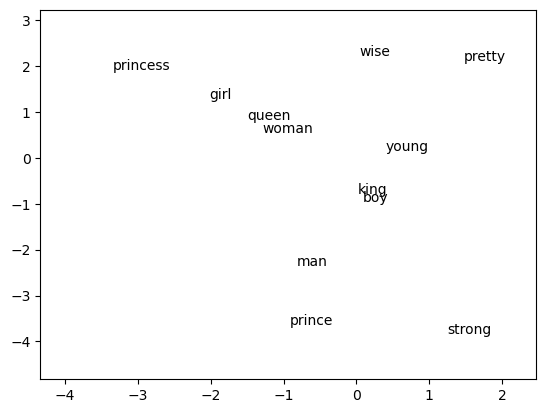

In [21]:
plt.figure(figsize=(16, 12))
fig, ax = plt.subplots()
for word, x1, x2 in zip(w2v_df.word, w2v_df.x1, w2v_df.x2):
     ax.annotate(word, (x1, x2))
x_axis_min = np.amin(vectors, axis=0)[0] - 1.0
x_axis_max = np.amax(vectors, axis=0)[0] + 1.0
y_axis_min = np.amin(vectors, axis=0)[1] - 1.0
y_axis_max = np.amax(vectors, axis=0)[1] + 1.0

plt.xlim(x_axis_min, x_axis_max)
plt.ylim(y_axis_min, y_axis_max)
plt.show()